### Download speeches

In [2]:
import urllib.request
import xml.etree.ElementTree as ET
import csv
import re
import sys
import matplotlib.pyplot as plt

TAG_RE = re.compile(r'<[^>]+>')
SPACE_RE = re.compile('&nbsp;')

In [97]:
import pandas as pd
import numpy as np

SENATOR_ID = 3398
MAX_SPEECHES = 10
f = urllib.request.urlopen("http://legis.senado.leg.br/dadosabertos/senador/"+ str(SENATOR_ID) +"/discursos")
raw = f.read()
root = ET.fromstring(raw)

print("Downloading speeches ")
parlamentar = root.find('Parlamentar')
i = 0

data = []

alltexts = ''
with open("output/senator-speeches.csv", "w", encoding='utf-8') as ofile:
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    id = parlamentar.find("IdentificacaoParlamentar")
    for pr in parlamentar.find("Pronunciamentos").iter('Pronunciamento'):
        i = i + 1
        try:
    #         http://www25.senado.leg.br/web/atividade/pronunciamentos/-/p/texto/427686
            urlTexto = pr.find('UrlTexto').text
            f = urllib.request.urlopen(urlTexto)
            html = f.read().decode('utf-8')
    #         print('>>>' + html)

            html_frag = re.search('texto-integral">(.*)<div class="FooterMain"', html)
            if html_frag != None:
                text = TAG_RE.sub('', html_frag.group(1))
                text = SPACE_RE.sub('', text)
        #         print(text)

                row = [ id.find('CodigoParlamentar').text,
                        id.find('NomeParlamentar').text,
                        id.find('SexoParlamentar').text,
                        pr.find('SiglaTipoPronunciamento').text,
                        pr.find('DataPronunciamento').text,
                        pr.find('SiglaPartidoParlamentarNaData').text,
                        pr.find('UfParlamentarNaData').text,
                        pr.find('NomeCasaPronunciamento').text,
                        text,
                      ]
                writer.writerow(row)
        #         print('>>>> ' + text)
                alltexts = alltexts + '\n' + text
                data.append(text)
        #         print("speech " + row[1] + " " + row[4])
                sys.stdout.write('.')
            else:
                print("Unavailable " + urlTexto)

            if i > MAX_SPEECHES:
                break
        except Exception as e:
            print('exception ' + str(e))
            if i > MAX_SPEECHES:
                break

speeches = data

print("Done")

...........Done


### Cleanup and tokenize documents words

In [431]:
import nltk
import re
from nltk.corpus import floresta
from nltk.stem import SnowballStemmer

stopwords = list(set([line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8')]))
# stopwords = []

#documents - [string contents]
def tokenize_filter_stem(documents, stopwords=[], word_min_size=3, word_filter_regex='.*', stemmer_language=None):
    stemmer = None
    if stemmer_language != None:
        stemmer = SnowballStemmer(stemmer_language)
    def stem(word):
        if stemmer != None:
            return stemmer.stem(word)
        else:
            return word
    tokens = [nltk.word_tokenize(s) for s in documents]
    tokens = [[stem(t.lower()) for t in tt if (len(t)>=word_min_size) and (t not in stopwords) and (re.match(word_filter_regex, t.lower()))] for tt in tokens]
    return tokens

# tokens = tokenize_filter_stem(speeches, stopwords, word_min_size=3, filter_regex='[a-z]', stemmer_language='portuguese')
tokens = tokenize_filter_stem(speeches, stopwords, word_min_size=2, word_filter_regex='[a-z]')
print([len(a) for a in tokens])

[83, 1111, 1079, 1480, 1162, 256, 1862, 2094, 1011, 692, 1030]


### Explore TFID Vectorizer

In [441]:
from sklearn.feature_extraction.text import TfidfVectorizer
alltexts = []
cont = ''
for d in tokens:
    for c in d:
        cont = cont + c + ' '
    alltexts.append(cont)
# print(alltexts)
vectorizer = TfidfVectorizer(min_df=10, analyzer='word', ngram_range=(1, 2))
vz = vectorizer.fit_transform(alltexts)
feature_names = vectorizer.get_feature_names()
df = pd.DataFrame(vz.todense().tolist(), columns=feature_names)
dfsum = df.sum().sort_values()
# print(dfsum)
# df.head(40)

In [442]:
from wordcloud import WordCloud

def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40, random_state=42).generate(text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

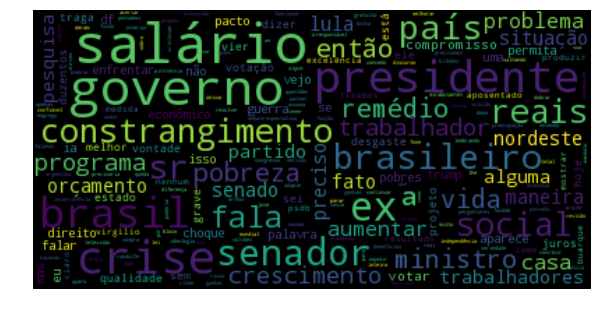

In [444]:
plot_word_cloud(dfsum.sort_values(ascending=False))

### Explore KMeans clustering

Our starting point is the tf-idf matrix vz. Let's check its size again.

In [445]:
vz.shape

(11, 1824)

This matrix can be seen as a collection of (x) high-dimensional vectors (y). Some algorithms like K-means can crunch this data structure and produce blocks of similar or "close" data points based on some similarity measure like the euclidean distance.

Kmeans needs the number of cluster as parameter. This number is usually determined by trying out different values until the result satisfies a given metrics (silhouette score or distorsion)

In [446]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

We can pick the number of clusters by varying it in a range of possible values and compute the silhouette score and the distorsion at every iteration. The optimal number is the one that maximizes the first and minimizes the second.

In [447]:
num_clusters = 3
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42,                       
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000, )
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

In [448]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
all_keywords = []
for i in range(num_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :20]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(num_clusters)], 
                           columns=['keyword_{0}'.format(i) for i in range(20)],
                           data=all_keywords)
keywords_df

keyword_0 keyword_1   keyword_2 keyword_3 keyword_4 keyword_5  \
topic_0     salário       exª  presidente        sr   senador    brasil   
topic_1  presidente     trump     senador     temer   impedir        sr   
topic_2     salário   governo  presidente    brasil     crise       exª   

        keyword_6 keyword_7 keyword_8         keyword_9     keyword_10  \
topic_0   governo    social      país         cristovam  sr presidente   
topic_1    deixar   decisão  randolfe  senador randolfe           pela   
topic_2    social        sr   senador              país  sr presidente   

                   keyword_11         keyword_12           keyword_13  \
topic_0     cristovam buarque            buarque                 casa   
topic_1  florestas permitindo          florestas  consultar congresso   
topic_2               buarque  cristovam buarque            cristovam   

        keyword_14   keyword_15    keyword_16 keyword_17     keyword_18  \
topic_0      crise  trabalhador            pt     senado             se   
topic_1  consultar   pela ordem  temer quiser     quiser    aquecimento   
topic_2    pobreza           se   crescimento     choque  choque social   

            keyword_19  
topic_0          bloco  
topic_1  temer deixado  
topic_2          reais